In [166]:
import torch as tc 
from torch import optim, nn 
from torch.utils.data import TensorDataset, DataLoader, random_split 

from torchvision import datasets 
from torchvision import transforms as T 
from torchvision import models

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from torchmetrics import Accuracy

from tqdm import tqdm 

In [167]:
transform_train = T.Compose([T.ToTensor(), T.Resize(size = (200, 200))])
transform_valid = T.Compose([T.ToTensor(), T.Resize(size = (200, 200))])

In [168]:
train_dataset = datasets.ImageFolder('/home/ahmadrezabaqerzadeh/datasets/DATA/Cat&dog/Dataset', transform = transform_train)
valid_dataset = datasets.ImageFolder('/home/ahmadrezabaqerzadeh/datasets/DATA/Cat&dog/Validation', transform = transform_valid)

In [169]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: /home/ahmadrezabaqerzadeh/datasets/DATA/Cat&dog/Dataset
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(200, 200), interpolation=bilinear, max_size=None, antialias=None)
           )

In [170]:
valid_dataset

Dataset ImageFolder
    Number of datapoints: 10
    Root location: /home/ahmadrezabaqerzadeh/datasets/DATA/Cat&dog/Validation
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(200, 200), interpolation=bilinear, max_size=None, antialias=None)
           )

In [171]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 5, shuffle  = False)

In [172]:
x, y = next(iter(train_loader))

In [173]:
device = 'cuda' if tc.cuda.is_available() else 'cpu'

In [174]:
class CNNModel(nn.Module):
    
    def __init__(self, out_channels, kernel_size, num_classes):
        super().__init__()
        
        self.conv1 = nn.LazyConv2d(out_channels[0], kernel_size[0], 1, 1)
        self.bn1 = nn.LazyBatchNorm2d()
        self.mpool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.LazyConv2d(out_channels[1], kernel_size[1], 1, 1)
        self.bn2 = nn.LazyBatchNorm2d()
        self.mpool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.LazyConv2d(out_channels[2], kernel_size[2], 1, 1)
        self.bn3 = nn.LazyBatchNorm2d()
        self.apool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc = nn.LazyLinear(num_classes)
        
    def forward(self, x):
        
        y = self.conv1(x)
        y = self.bn1(y)
        y = y.relu()
        y = self.mpool1(y)
        
        y = self.conv2(x)
        y = self.bn2(y)
        y = y.relu()
        y = self.mpool2(y)
        
        y = self.conv3(x)
        y = self.bn3(y)
        y = y.relu()
        
        y = self.apool(y)
        
        y = y.flatten(1)
        
        y = self.fc(y)
        
        return y

In [175]:
model  = CNNModel([16, 32, 64], [3, 3, 3], 5).to(device)

In [176]:
model(x.to(device)).shape

torch.Size([32, 5])

In [177]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [178]:
def train_one_epoch(model, train_loader, loss_func, optimizer, epoch):
    model.train()

    train_loss=AverageMeter()
    train_acc=Accuracy(task='multiclass', num_classes=5).to(device)

    with tqdm(train_loader, unit='batch') as tepoch:
        for x, y in tepoch:
            if epoch is not None:
                tepoch.set_description(f'Epoch={epoch}')

            x=x.to(device)
            y=y.to(device)

            yp=model(x)
        
            loss=loss_func(yp.squeeze(),  y)
            loss.backward()
            #nn.utils.clip_grad_norm(model.parameters(), 0.5)
            optimizer.step()
            optimizer.zero_grad()

            train_loss.update(loss.item())
            train_acc(yp.squeeze(), y.int())

            tepoch.set_postfix(loss=train_loss.avg, Accuracy=train_acc.compute().item() * 100)

    return model, train_loss.avg, train_acc.compute().item()

In [179]:
def validation(model, valid_loaedr, loss_func):
    model.eval()

    valid_loss=AverageMeter()
    valid_acc=Accuracy(task='multiclass', num_classes=5).to(device)

    for x, y in valid_loaedr:

        x=x.to(device)
        y=y.to(device)

        yp=model(x)
        loss=loss_func(yp.squeeze(), y)

        valid_loss.update(loss.item())
        valid_acc(yp.squeeze(), y)

    print(f'valid loss={valid_loss.avg:.4}, accuracy={valid_acc.compute().item() * 100 :.4}')
    print()

    return valid_loss.avg, valid_acc.compute().item()

In [180]:
model = CNNModel([8, 32, 64], [5, 5, 5], 5).to(device)

In [181]:
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 1e-4)
loss_func = nn.CrossEntropyLoss()

In [182]:
loss_train_hist, acc_train_hist = [], [] 
loss_valid_hist, acc_valid_hist = [], []
best_model = [0]
best_loss = tc.inf

In [183]:
N = 20
for i in range(N):

  model, train_loss, train_acc = train_one_epoch(model, train_loader, loss_func, optimizer, i)
  valid_loss, valid_acc = validation(model, valid_loader, loss_func)

  acc_train_hist.append(train_acc)
  loss_train_hist.append(train_loss)

  acc_valid_hist.append(valid_acc)
  loss_valid_hist.append(valid_loss)

  if valid_loss<best_loss:
    best_loss = valid_loss
    best_model[0] = model
    print('model saved!')

Epoch=0: 100%|██████████| 63/63 [00:13<00:00,  4.53batch/s, Accuracy=48.8, loss=1.11]


valid loss=0.7683, accuracy=70.0

model saved!


Epoch=1: 100%|██████████| 63/63 [00:14<00:00,  4.49batch/s, Accuracy=55.9, loss=0.811]


valid loss=0.6794, accuracy=70.0

model saved!


Epoch=2: 100%|██████████| 63/63 [00:13<00:00,  4.51batch/s, Accuracy=59.5, loss=0.753]


valid loss=0.6316, accuracy=80.0

model saved!


Epoch=3: 100%|██████████| 63/63 [00:13<00:00,  4.53batch/s, Accuracy=60.3, loss=0.728]


valid loss=0.6236, accuracy=80.0

model saved!


Epoch=4: 100%|██████████| 63/63 [00:14<00:00,  4.48batch/s, Accuracy=58.9, loss=0.714]


valid loss=0.5986, accuracy=60.0

model saved!


Epoch=5: 100%|██████████| 63/63 [00:14<00:00,  4.48batch/s, Accuracy=59.1, loss=0.704]


valid loss=0.5923, accuracy=70.0

model saved!


Epoch=6: 100%|██████████| 63/63 [00:13<00:00,  4.53batch/s, Accuracy=58.3, loss=0.699]


valid loss=0.5841, accuracy=70.0

model saved!


Epoch=7: 100%|██████████| 63/63 [00:14<00:00,  4.50batch/s, Accuracy=59.1, loss=0.693]


valid loss=0.5815, accuracy=80.0

model saved!


Epoch=8: 100%|██████████| 63/63 [00:13<00:00,  4.55batch/s, Accuracy=57.7, loss=0.688]


valid loss=0.586, accuracy=70.0



Epoch=9: 100%|██████████| 63/63 [00:14<00:00,  4.50batch/s, Accuracy=57.6, loss=0.686]


valid loss=0.5894, accuracy=70.0



Epoch=10: 100%|██████████| 63/63 [00:14<00:00,  4.48batch/s, Accuracy=58.2, loss=0.685]


valid loss=0.5853, accuracy=80.0



Epoch=11: 100%|██████████| 63/63 [00:14<00:00,  4.47batch/s, Accuracy=57.8, loss=0.681]


valid loss=0.5732, accuracy=70.0

model saved!


Epoch=12: 100%|██████████| 63/63 [00:14<00:00,  4.48batch/s, Accuracy=58.9, loss=0.68] 


valid loss=0.5722, accuracy=60.0

model saved!


Epoch=13: 100%|██████████| 63/63 [00:13<00:00,  4.50batch/s, Accuracy=58.1, loss=0.678]


valid loss=0.5586, accuracy=70.0

model saved!


Epoch=14: 100%|██████████| 63/63 [00:14<00:00,  4.45batch/s, Accuracy=58.6, loss=0.676]


valid loss=0.5684, accuracy=60.0



Epoch=15: 100%|██████████| 63/63 [00:14<00:00,  4.43batch/s, Accuracy=58.7, loss=0.676]


valid loss=0.5875, accuracy=70.0



Epoch=16: 100%|██████████| 63/63 [00:14<00:00,  4.44batch/s, Accuracy=57.8, loss=0.676]


valid loss=0.5875, accuracy=60.0



Epoch=17: 100%|██████████| 63/63 [00:14<00:00,  4.47batch/s, Accuracy=59.1, loss=0.674]


valid loss=0.5811, accuracy=60.0



Epoch=18: 100%|██████████| 63/63 [00:14<00:00,  4.40batch/s, Accuracy=58.1, loss=0.675]


valid loss=0.5808, accuracy=60.0



Epoch=19: 100%|██████████| 63/63 [00:13<00:00,  4.59batch/s, Accuracy=57.7, loss=0.672]

valid loss=0.5761, accuracy=70.0



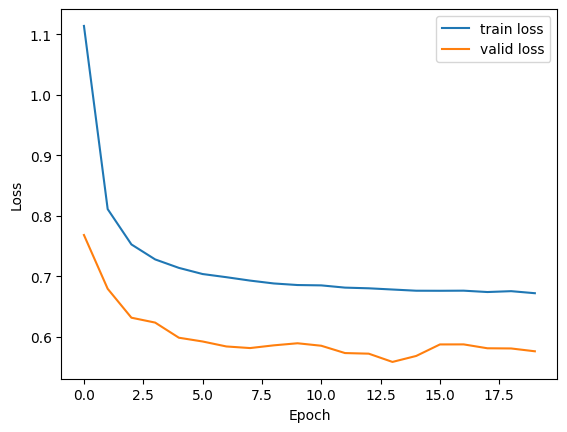

In [184]:
plt.plot(range(N), loss_train_hist, label = 'train loss')
plt.plot(range(N), loss_valid_hist, label = 'valid loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()